In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from scipy.stats import norm

# Import Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

In [2]:
data = pd.read_csv('ds_salaries.csv')

In [3]:
data.head(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
5,2023,SE,FT,Applied Scientist,222200,USD,222200,US,0,US,L
6,2023,SE,FT,Applied Scientist,136000,USD,136000,US,0,US,L
7,2023,SE,FT,Data Scientist,219000,USD,219000,CA,0,CA,M
8,2023,SE,FT,Data Scientist,141000,USD,141000,CA,0,CA,M
9,2023,SE,FT,Data Scientist,147100,USD,147100,US,0,US,M


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


## 데이터전처리

In [7]:
# LabelEncoder로 카테고리 변수 변환
cols = ['experience_level', 'employment_type', 'job_title','salary_currency','employee_residence','company_location','company_size']
data[cols]=data[cols].apply(LabelEncoder().fit_transform)

# X, y
X = data.drop(["salary_in_usd"], axis=1)
y = data["salary_in_usd"]

# train and test sets 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
data.head(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,3,2,84,80000,7,85847,26,100,25,0
1,2023,2,0,66,30000,19,30000,75,100,70,2
2,2023,2,0,66,25500,19,25500,75,100,70,2
3,2023,3,2,47,175000,19,175000,11,100,12,1
4,2023,3,2,47,120000,19,120000,11,100,12,1
5,2023,3,2,8,222200,19,222200,75,0,70,0
6,2023,3,2,8,136000,19,136000,75,0,70,0
7,2023,3,2,47,219000,19,219000,11,0,12,1
8,2023,3,2,47,141000,19,141000,11,0,12,1
9,2023,3,2,47,147100,19,147100,75,0,70,1


## 상관관계 분석

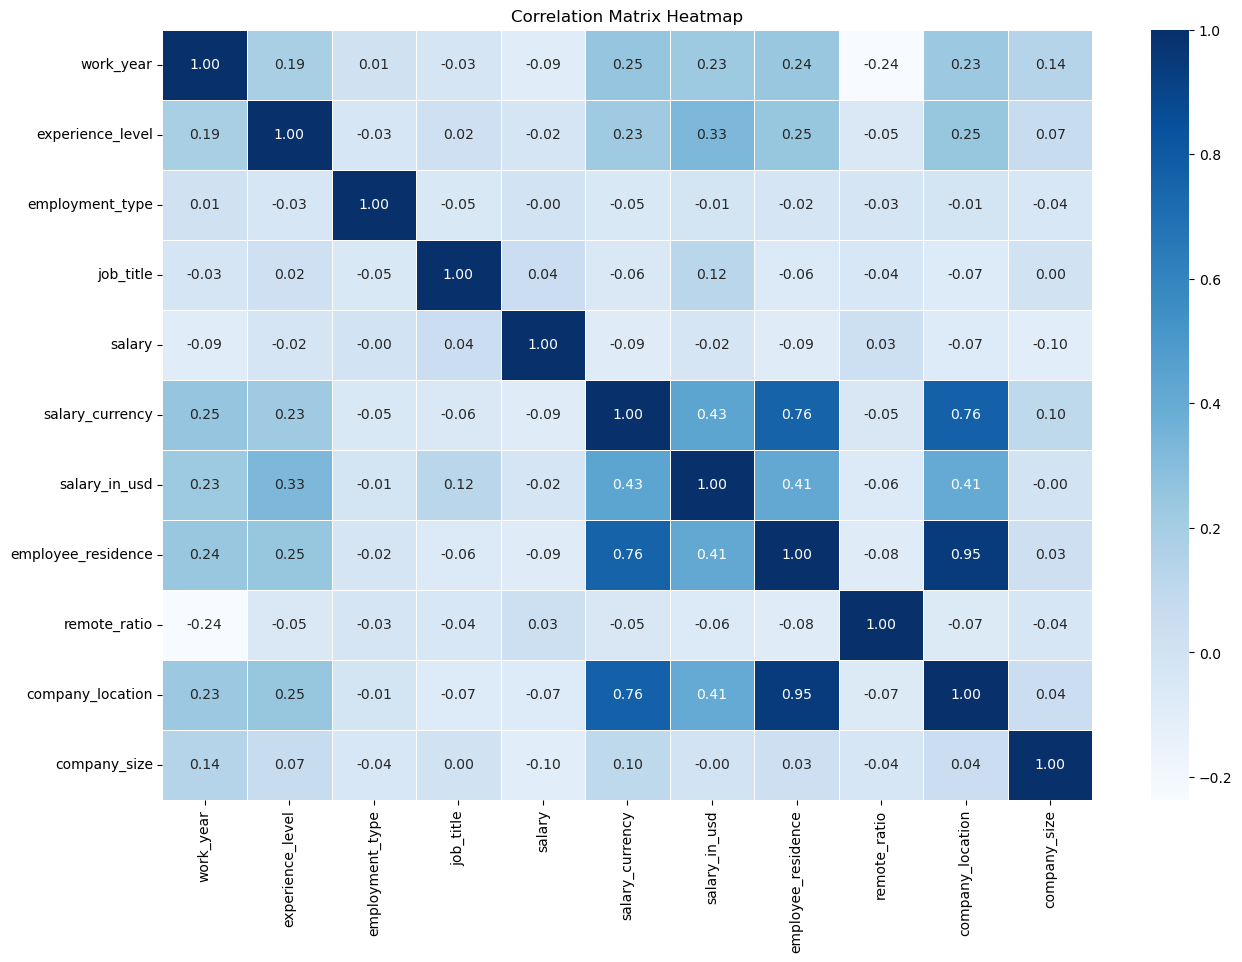

In [9]:
correlation_matrix = data.corr()

plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

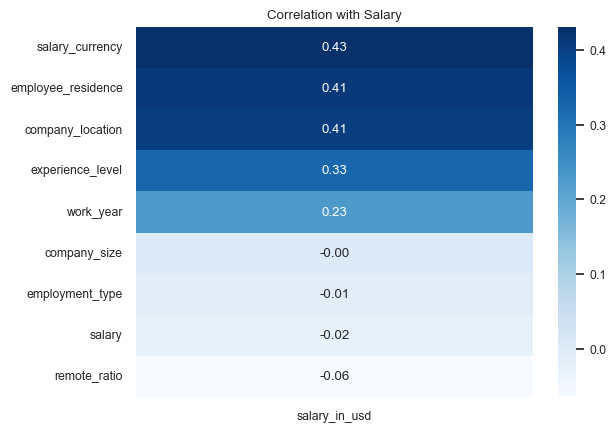

In [60]:
corr = data.corr()
target_corr = corr['salary_in_usd'].drop('salary_in_usd')

target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("Blues")
sns.heatmap(target_corr_sorted.to_frame(), cmap="Blues", annot=True, fmt='.2f')
plt.title("Correlation with Salary")
plt.show()

## Modeling

In [11]:
#Regression을 활용해서 다른 요소들로 Salary 예측하는 모델링

def xgb_objective(trial):
    # .suggest_int - 정수형 하이퍼파라미터를 특정 값 사이에서 추천받을 수 있다
    # 추천받은 값을 모델의 학습 과정에 적용하여 성능을 평가한다
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    
    model = XGBRegressor(
        n_estimators = n_estimators,
        learning_rate = learning_rate,
        max_depth = max_depth,
        subsample = subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

def catboost_objective(trial):
    iterations = trial.suggest_int("iterations", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    depth = trial.suggest_int("depth", 3, 10)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 9)
    subsample = trial.suggest_float("subsample", 0.5, 1)

    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        random_state=42,
        verbose=0
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [12]:
from optuna.samplers import TPESampler
import optuna

In [13]:
sampler = TPESampler(seed=42)
# TPESampler를 생성할 때 시드 값을 임의로 42로 설정하고, 이를 통해 하이퍼파라미터 탐색 과정에서 난수를 제어하고 재현성을 확보합니다. 
# 이는 실험을 반복하거나 결과를 공유할 때 유용

xgb_study = optuna.create_study(direction="maximize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=50) 

catboost_study = optuna.create_study(direction="maximize", sampler=sampler)
catboost_study.optimize(catboost_objective, n_trials=50) 

# trials 50번 후 best parameter 조합 출력
print("Best parameters for XGBoost from Optuna: ", xgb_study.best_params)
print("Best parameters for CatBoost from Optuna: ", catboost_study.best_params)

[I 2023-08-03 16:08:52,996] A new study created in memory with name: no-name-40631f2e-91da-48d4-b1f7-780b213ac201
[I 2023-08-03 16:08:53,747] Trial 0 finished with value: 0.9548394932934728 and parameters: {'n_estimators': 250, 'learning_rate': 0.19063571821788408, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 0.9548394932934728.
[I 2023-08-03 16:08:54,333] Trial 1 finished with value: 0.9586385228087078 and parameters: {'n_estimators': 162, 'learning_rate': 0.021035886311957897, 'max_depth': 9, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 0.9586385228087078.
[I 2023-08-03 16:08:54,670] Trial 2 finished with value: 0.9513018362259866 and parameters: {'n_estimators': 108, 'learning_rate': 0.19428287191077892, 'max_depth': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 0.9586385228087078.
[I 2023-08-03 1

[I 2023-08-03 16:09:11,813] Trial 28 finished with value: 0.9756391032978379 and parameters: {'n_estimators': 450, 'learning_rate': 0.05192974066150293, 'max_depth': 5, 'subsample': 0.9133550130394151, 'colsample_bytree': 0.8874398885345842}. Best is trial 17 with value: 0.9856021159483488.
[I 2023-08-03 16:09:12,150] Trial 29 finished with value: 0.9834112640495529 and parameters: {'n_estimators': 259, 'learning_rate': 0.16998902647868241, 'max_depth': 3, 'subsample': 0.8123316744836291, 'colsample_bytree': 0.8457833000533787}. Best is trial 17 with value: 0.9856021159483488.
[I 2023-08-03 16:09:13,007] Trial 30 finished with value: 0.9605461219614982 and parameters: {'n_estimators': 262, 'learning_rate': 0.17397842580928163, 'max_depth': 8, 'subsample': 0.8209621217456762, 'colsample_bytree': 0.8195875480925692}. Best is trial 17 with value: 0.9856021159483488.
[I 2023-08-03 16:09:13,310] Trial 31 finished with value: 0.9867423943124463 and parameters: {'n_estimators': 232, 'learning

[I 2023-08-03 16:09:24,157] Trial 7 finished with value: 0.9769357394243988 and parameters: {'iterations': 230, 'learning_rate': 0.1486251738842322, 'depth': 8, 'l2_leaf_reg': 8, 'subsample': 0.7361074625809747}. Best is trial 0 with value: 0.9802462281551148.
[I 2023-08-03 16:09:24,459] Trial 8 finished with value: 0.9758571838968245 and parameters: {'iterations': 147, 'learning_rate': 0.14551650957236906, 'depth': 9, 'l2_leaf_reg': 6, 'subsample': 0.8854835899772805}. Best is trial 0 with value: 0.9802462281551148.
[I 2023-08-03 16:09:24,724] Trial 9 finished with value: 0.9702372718456832 and parameters: {'iterations': 298, 'learning_rate': 0.10931923758257887, 'depth': 6, 'l2_leaf_reg': 1, 'subsample': 0.5539457134966522}. Best is trial 0 with value: 0.9802462281551148.
[I 2023-08-03 16:09:24,863] Trial 10 finished with value: 0.9670940826044339 and parameters: {'iterations': 109, 'learning_rate': 0.1952801926862604, 'depth': 7, 'l2_leaf_reg': 9, 'subsample': 0.8156367309350179}. B

[I 2023-08-03 16:09:49,567] Trial 39 finished with value: 0.9819875273478983 and parameters: {'iterations': 406, 'learning_rate': 0.07912058249603174, 'depth': 9, 'l2_leaf_reg': 9, 'subsample': 0.7592556085719147}. Best is trial 28 with value: 0.9833014280844262.
[I 2023-08-03 16:09:49,961] Trial 40 finished with value: 0.9718527555555866 and parameters: {'iterations': 336, 'learning_rate': 0.08001488399110605, 'depth': 7, 'l2_leaf_reg': 8, 'subsample': 0.7849832548829533}. Best is trial 28 with value: 0.9833014280844262.
[I 2023-08-03 16:09:50,762] Trial 41 finished with value: 0.9772602150956696 and parameters: {'iterations': 406, 'learning_rate': 0.06376074469311949, 'depth': 9, 'l2_leaf_reg': 9, 'subsample': 0.7499450935715685}. Best is trial 28 with value: 0.9833014280844262.
[I 2023-08-03 16:09:51,622] Trial 42 finished with value: 0.977352825009768 and parameters: {'iterations': 446, 'learning_rate': 0.10677980606248903, 'depth': 9, 'l2_leaf_reg': 9, 'subsample': 0.7102730287017

Best parameters for XGBoost from Optuna:  {'n_estimators': 270, 'learning_rate': 0.1791601242857069, 'max_depth': 4, 'subsample': 0.8047461235876247, 'colsample_bytree': 0.8631105050976219}
Best parameters for CatBoost from Optuna:  {'iterations': 465, 'learning_rate': 0.13287446447466042, 'depth': 9, 'l2_leaf_reg': 8, 'subsample': 0.7138287081101418}


## Machine Learning

In [14]:
#best parameters를 사용해서 설정해주기
xgb_best_params = {'n_estimators': 270, 'learning_rate': 0.1791601242857069, 'max_depth': 4, 'subsample': 0.8047461235876247, 'colsample_bytree': 0.8631105050976219}
catboost_best_params = {'iterations': 465, 'learning_rate': 0.13287446447466042, 'depth': 9, 'l2_leaf_reg': 8, 'subsample': 0.7138287081101418}

#Train base models with the best parameters
xgb = XGBRegressor(**xgb_best_params, random_state=42)
catboost = CatBoostRegressor(**catboost_best_params, random_state=42, verbose=0)

In [17]:
#Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression

# SelectKBest 변환기 - 주어진 특성들 중에서 최상의 k개 특성을 선택하기 위한 것
# f_regression - 특성의 중요도를 평가하는 함수
selector = SelectKBest(score_func=f_regression)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

### VotingRegressor 가중치 부여 & Cross Validation

In [20]:
from sklearn.ensemble import VotingRegressor

# Combine the base models to create an ensemble and assign weights
weights = [0.6, 0.4]
# Combine the base models to create an ensemble
ensemble = VotingRegressor([('xgb', xgb),('catboost', catboost)])
# Train the ensemble model using selected features
ensemble.fit(X_train_selected, y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8631105050976219,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1791601242857069,
                                          max_bin=None, max_cat_th

In [22]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble, X_train_selected, y_train, cv=kfold, scoring='r2')

print("Cross-validation scores: ", cv_scores)
print("Mean CV R-squared: {:.2f}".format(np.mean(cv_scores)))
print("Standard Deviation of CV R-squared: {:.2f}".format(np.std(cv_scores)))

Cross-validation scores:  [0.98611957 0.98501504 0.97857334 0.89648249 0.98501691]
Mean CV R-squared: 0.97
Standard Deviation of CV R-squared: 0.03


In [23]:
# selected features y_pred 만들기
y_pred = ensemble.predict(X_test_selected)

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: {:.2f}".format(mse))
print("R-squared: {:.2f}".format(r2))

Mean Squared Error: 49046248.91
R-squared: 0.99


In [73]:
#가중치를 다르게 하면 어떻게 될까? catboost 가중치를 더 크게 줘보기

In [70]:
from sklearn.ensemble import VotingRegressor

# Combine the base models to create an ensemble and assign weights
weights = [0.3, 0.7]
# Combine the base models to create an ensemble
ensemble = VotingRegressor([('xgb', xgb),('catboost', catboost)])
# Train the ensemble model using selected features
ensemble.fit(X_train_selected, y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8631105050976219,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1791601242857069,
                                          max_bin=None, max_cat_th

In [71]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(ensemble, X_train_selected, y_train, cv=kfold, scoring='r2')

print("Cross-validation scores: ", cv_scores)
print("Mean CV R-squared: {:.2f}".format(np.mean(cv_scores)))
print("Standard Deviation of CV R-squared: {:.2f}".format(np.std(cv_scores)))

Cross-validation scores:  [0.98611957 0.98501504 0.97857334 0.89648249 0.98501691]
Mean CV R-squared: 0.97
Standard Deviation of CV R-squared: 0.03


In [74]:
# selected features y_pred 만들기
y_pred = ensemble.predict(X_test_selected) #여기에 x_train을 넣어보기 (봤던 데이터를 잘예측하고있는지로 과적합 판별 )

# Evaluate the performance
mse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: {:.2f}".format(mse)) #루트씌워봐야 좀더 정확한 수치
print("R-squared: {:.2f}".format(r2))

Mean Squared Error: 7003.30
R-squared: 0.99


In [ ]:
# R-squared 값이 높다는 것 -> 모델이 데이터에 매우 잘 적합되었다는 의미

# 그러나, 주의할 점이 있다!
# Overfitting 가능성: 너무 높은 R-squared 값은 모델이 학습 데이터에 대해 너무 많이 적합되었을 수 있음을 나타낼 수 있습니다. 
#     이는 모델이 노이즈까지 학습했을 가능성을 높일 수 있습니다. 새로운 데이터에 대한 예측 능력이 떨어질 수 있습니다.

# Generalization: 모델의 목적은 새로운 데이터에 대한 예측 능력을 향상시키는 것입니다. 
#     따라서 R-squared 값이 높더라도, 모델이 새로운 데이터에 대해 얼마나 잘 수행하는지 평가해보아야 합니다.

# 비선형 모델: 높은 R-squared 값이라고 해서 모델이 항상 좋은 것은 아닙니다. 
#     데이터가 비선형적인 관계를 가질 경우, 높은 R-squared 값이 선형 모델의 좋은 적합을 나타내지 않을 수 있습니다.

# 

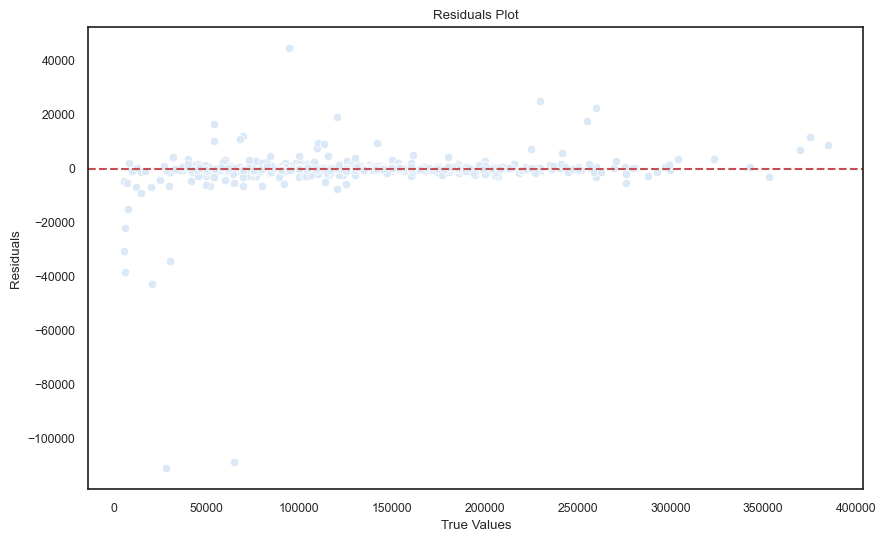

In [24]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [26]:
selected_features = data.drop('salary_in_usd', axis=1).columns
X_test = data[selected_features]

In [27]:
print(X.shape)

(3755, 10)


In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [29]:
# Scale 
X_test_scaled = scaler.transform(X_test)

# Make predictions
y_test_pred = ensemble.predict(X_test_scaled)

In [30]:
result_df = pd.DataFrame({'job_title': data['job_title'], 'salary_pred': y_test_pred})
result_df

,job_title,salary_pred
0,84,36965.299139
1,66,36094.245331
2,66,36094.245331
3,47,35912.489369
4,47,35912.489369
...,...,...
3750,47,35912.489369
3751,84,31365.646359
3752,47,35490.729607
3753,17,33797.406413


In [ ]:
#job_title에 있는 숫자를 다시 decoding해서 카테고리형으로 보고싶은 경우

In [43]:
data2 = pd.read_csv('ds_salaries.csv')

In [46]:
# 원래 데이터 백업

original = data2['job_title'].unique()
original

array(['Principal Data Scientist', 'ML Engineer', 'Data Scientist',
       'Applied Scientist', 'Data Analyst', 'Data Modeler',
       'Research Engineer', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Machine Learning Engineer',
       'Data Strategist', 'Data Engineer', 'Computer Vision Engineer',
       'Data Quality Analyst', 'Compliance Data Analyst',
       'Data Architect', 'Applied Machine Learning Engineer',
       'AI Developer', 'Research Scientist', 'Data Analytics Manager',
       'Business Data Analyst', 'Applied Data Scientist',
       'Staff Data Analyst', 'ETL Engineer', 'Data DevOps Engineer',
       'Head of Data', 'Data Science Manager', 'Data Manager',
       'Machine Learning Researcher', 'Big Data Engineer',
       'Data Specialist', 'Lead Data Analyst', 'BI Data Engineer',
       'Director of Data Science', 'Machine Learning Scientist',
       'MLOps Engineer', 'AI Scientist', 'Autonomous Vehicle Technician',
       'Applied Machine Learning Sc

In [55]:
# LabelEncoder로 카테고리 변수 변환

cols = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']
data[cols] = data[cols].apply(LabelEncoder().fit_transform)

In [56]:
# 딕셔너리 생성하여 원래 값들과 Label Encoding 값 매핑

experience_level_mapping = {label: category for label, category in zip(data['job_title'], original)}

In [57]:
# 특정 칼럼을 다시 카테고리형으로 변환

data['job_title'] = data['job_title'].map(experience_level_mapping)

In [58]:
result_df = pd.DataFrame({'job_title': data['job_title'], 'salary_pred': y_test_pred})
result_df

,job_title,salary_pred
0,Principal Data Scientist,36965.299139
1,Data Scientist,36094.245331
2,Data Scientist,36094.245331
3,Finance Data Analyst,35912.489369
4,Finance Data Analyst,35912.489369
...,...,...
3750,Finance Data Analyst,35912.489369
3751,Principal Data Scientist,31365.646359
3752,Finance Data Analyst,35490.729607
3753,NaN,33797.406413
